## 自编码

自编码器属于无监督模型, 不需要标注的数据, 用自身的高阶特征来编码自己.

这里涉及到稀疏编码, 所谓稀疏编码, 就是把高阶特征分解为低阶特征来稀疏表示.

可以把神经网络的前向过程看做从低阶特征向高阶特征过渡.

那么稀疏编码是反过来的过程, 从高阶特征向低阶特征转移. Sparce Encoding, 这里的稀疏可以是双向的.

在计算机视觉中, 我们需要从像素这样的低阶特征中学习高阶特征, 所谓编码就是从高阶到低阶过渡, 从而压缩信息, 自编码器的关键在编码, 用自身的高阶特征来编码自己. 特点如下

1. 希望输入输出一致
2. 希望使用高阶特征来重构自己.

DBN第一次使得训练深层网络成为可能.

从原始的自编码引入一些限制, 可以有一个特性.

1. 中间节点数目小于输入节点, 相当于降维.
2. 在输入数据中加入噪声, 就成了去噪自编码器. 常用的噪声是加性高斯噪声(Additive Gaussian Noise, AGN), 记忆Masking Noise, 即有随机遮挡的噪声, 这种情况下, 图像中的一部分像素被置0, 自编码器需要从其它像素的结构来推断被遮挡的像素, 因此依然需要学习高阶特征.

如果中间只有一层的话, 那么就相当于PCA, DBN中间有很多隐含层, 每一个隐含层都是一个RMB, 训练时, 对每两层之间进行无监督学习, 相当于多层的自编码器, 提取特征初始化网络权重, 最后在进行有监督的反向传播训练, 解决了梯度弥散问题. 这里相当于进行预训练.

主要的作用

1. 特征提取
2. 预训练

一般用的都是去噪自编码器. 更进一步的有变分自编码器.其特征如下

1. 对中间节点的分布有强假设
2. 有额外的损失项
3. 使用SGVB(Stochastic Gradient Variational Bayes)
4. 与GAN一起作为强大的生成模型


### Mnist Autoencoder

#### 参数初始化

这里用到一个比较常用的网络参数初始化方法, xavier initialization. 利用网络输出输出节点个数, 使得网络权重的均值等于0, 同时方差等于$\frac{2}{n_{in}+n_{out}}$, 生成方法可以利用高斯分布或者均匀分布, 如果是均匀分布, 则可以利用$(-\sqrt{\frac{6}{n_{in}+n_{out}}},\sqrt{\frac{6}{n_{in}+n_{out}}})$, 方差利用公式$\frac{(max-min)^2}{12}$

In [9]:
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
def xavier_init(fan_in, fan_out, constant = 1):
    low = -constant * np.sqrt(6.0 /(fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval = low, maxval = high, dtype = tf.float32)

In [3]:
class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function = tf.nn.softplus, optimizer = tf.train.AdamOptimizer(),
                 scale = 0.1):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder(tf.float32)
        self.training_scale = scale
        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden = self.transfer(tf.add(tf.matmul(self.x + scale * tf.random_normal((n_input,)),
                self.weights['w1']),
                self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict = {self.x: X,
                                                                            self.scale: self.training_scale
                                                                            })
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X,
                                                     self.scale: self.training_scale
                                                     })

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x: X,
                                                       self.scale: self.training_scale
                                                       })

    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size = self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x: X,
                                                               self.scale: self.training_scale
                                                               })

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])

In [4]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index:(start_index + batch_size)]


In [6]:
X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

In [7]:
n_samples = int(mnist.train.num_examples)
training_epochs = 20
batch_size = 128
display_step = 1

In [42]:
autoencoder = AdditiveGaussianNoiseAutoencoder(n_input = 784,
                                               n_hidden = 200,
                                               transfer_function = tf.nn.softplus,
                                               optimizer = tf.train.AdamOptimizer(learning_rate = 0.001),
                                               scale = 0.01)


In [43]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [44]:
def plot_10_by_10_images(images):
    """ Plot 100 MNIST images in a 10 by 10 table. Note that we crop
    the images so that they appear reasonably close together.  The
    image is post-processed to give the appearance of being continued."""
    images = np.array([np.reshape(image, (28,28)) for image in images])
    fig = plt.figure()
    #images = [image[3:25, 3:25] for image in images]
    #image = np.concatenate(images, axis=1)
    for x in range(10):
        for y in range(10):
            ax = fig.add_subplot(10, 10, 10*y+(x+1))
            ax.matshow(images[10*y+x], cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

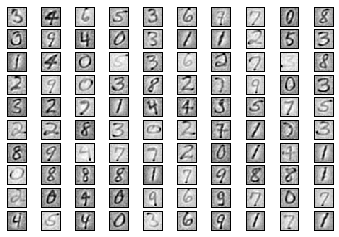

('Epoch:', '0001', 'cost=', '20890.923888636')


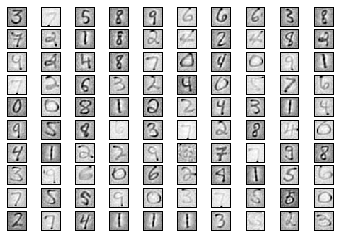

('Epoch:', '0002', 'cost=', '12711.952379545')


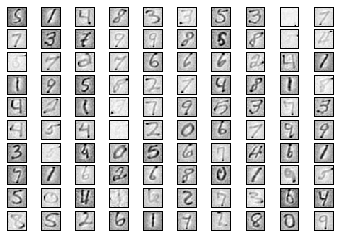

('Epoch:', '0003', 'cost=', '11523.939795455')


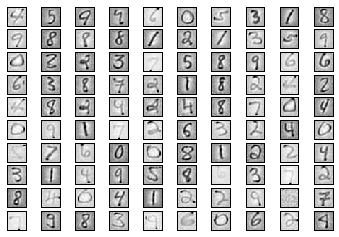

('Epoch:', '0004', 'cost=', '9875.824055682')


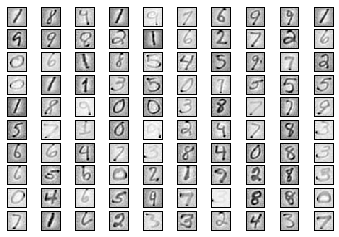

('Epoch:', '0005', 'cost=', '9599.694776705')


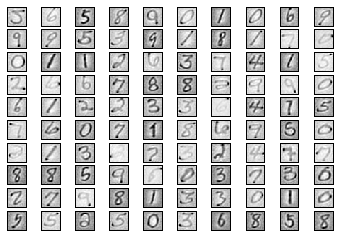

('Epoch:', '0006', 'cost=', '9001.732538636')


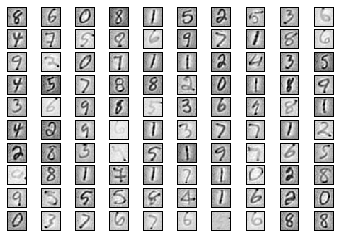

('Epoch:', '0007', 'cost=', '8762.459242045')


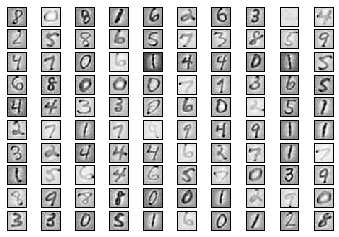

('Epoch:', '0008', 'cost=', '8935.635742614')


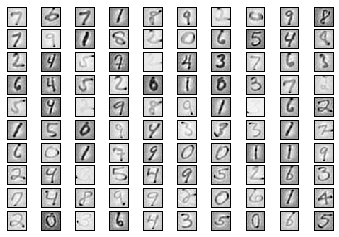

('Epoch:', '0009', 'cost=', '8137.662203977')


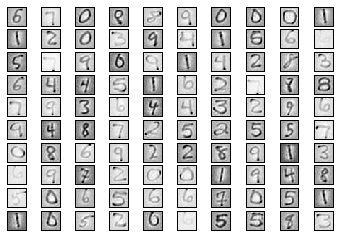

('Epoch:', '0010', 'cost=', '8217.766906250')


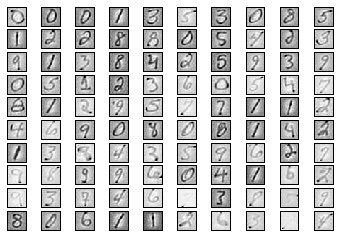

('Epoch:', '0011', 'cost=', '8147.456087500')


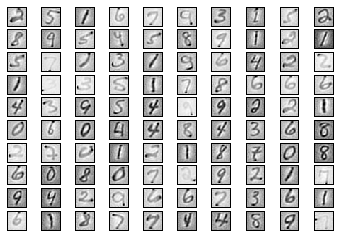

('Epoch:', '0012', 'cost=', '8014.842109091')


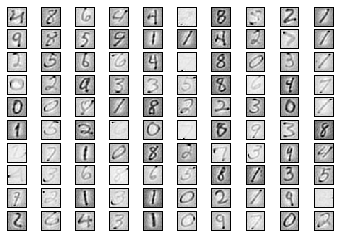

('Epoch:', '0013', 'cost=', '8149.434415341')


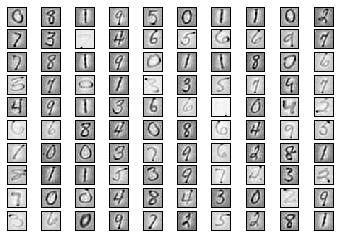

('Epoch:', '0014', 'cost=', '8244.694694318')


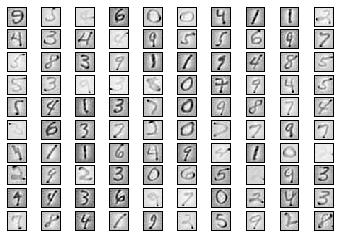

('Epoch:', '0015', 'cost=', '7742.195983523')


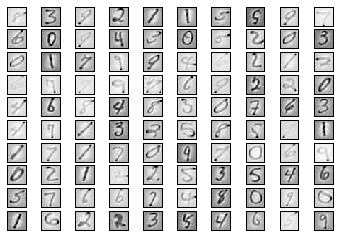

('Epoch:', '0016', 'cost=', '8637.649313636')


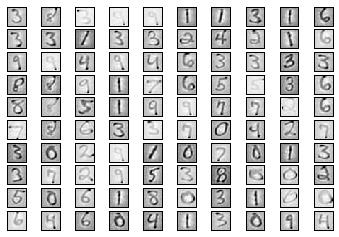

('Epoch:', '0017', 'cost=', '8078.860419886')


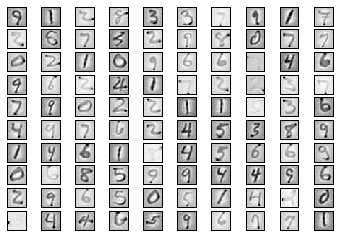

('Epoch:', '0018', 'cost=', '7793.797742614')


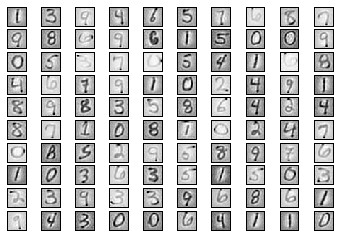

('Epoch:', '0019', 'cost=', '7957.518545455')


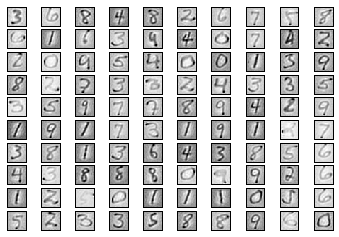

('Epoch:', '0020', 'cost=', '7491.963491477')
Total cost: 675218.0


In [45]:
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)

        # Fit training using batch data
        cost = autoencoder.partial_fit(batch_xs)
        # Compute average loss
        avg_cost += cost / n_samples * batch_size

    # Display logs per epoch step
    if epoch % display_step == 0 or epoch == 0:
        batch_xs = batch_xs[:100]
        reconstruct_img = autoencoder.reconstruct(batch_xs)
        plot_10_by_10_images(reconstruct_img)
        print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

print("Total cost: " + str(autoencoder.calc_total_cost(X_test)))


Autoencoder作为深度学习在无监督学习中的应用是非常成功的, 可以用来为模型初始化参数, 但是现在用的比较少了, 可以用来提取高阶特征.

## MLP

为了防止深层网络的过拟合, 一般有三种方法(DAR)

1. Dropout
2. Adam, AdaGrad(改进的随机梯度算法)
3. ReLu

其中Dropout相当于随机丢弃某一层的输出数据, 相当于创造出很多的随机样本, 通过增大样本量, 减少特征数目来防止过拟合, 也是一种bagging方法.

MLP可以解决XOR问题, 因为XOR问题是线性不可分的, 引入隐含层之后可以学习非线性的曲线来进行划分.

In [46]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
sess = tf.InteractiveSession()

in_units = 784
h1_units = 300
W1 = tf.Variable(tf.truncated_normal([in_units, h1_units], stddev=0.1))
b1 = tf.Variable(tf.zeros([h1_units]))
W2 = tf.Variable(tf.zeros([h1_units, 10]))
b2 = tf.Variable(tf.zeros([10]))

x = tf.placeholder(tf.float32, [None, in_units])
keep_prob = tf.placeholder(tf.float32)

hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1)
hidden1_drop = tf.nn.dropout(hidden1, keep_prob)
y = tf.nn.softmax(tf.matmul(hidden1_drop, W2) + b2)

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.AdagradOptimizer(0.3).minimize(cross_entropy)

# Train
tf.global_variables_initializer().run()
for i in range(3000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  train_step.run({x: batch_xs, y_: batch_ys, keep_prob: 0.75})

# Test trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.9785
